# Transfer Learning

### Transfer learning approach using deep learning (Sequential Neural Network model):

### Steps
- Initial SHAREw8 Neural Network training (knowledge/ features learned through this network were saved - refer to final06_SHAREw8_NNmodel_weights.h5)
- Transfer learning to ADNI Neaural Network
- Baseline ADNI Neural Network for comparison


In [1]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [2]:
import zipfile
import os

# Path to the zip file
zip_file_path = '/content/drive/MyDrive/sharew8_rel8-0-0_ALL_datasets_stata.zip'

# Destination folder where you want to unzip the contents
destination_folder = '/content/drive/MyDrive/SHAREw8'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

In [2]:
import os
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
from itertools import combinations
from joblib import Parallel, delayed
import glob
from functools import reduce
import geopandas.tools
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import joblib
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification

In [3]:
# Specify the path to the dataset directory
directory_path = '/content/drive/MyDrive/SHAREw8/'
dataset = []

# List all .dta files in the directory
files = glob.glob(os.path.join(directory_path, '*.dta'))

def check_structure(file_path, sample_data):
    try:
        data = pd.read_stata(file_path)
        dataset.append(data)
        return data.info() == sample_data.info()
    except Exception as e:
        print(f"Error reading {os.path.basename(file_path)}: {e}")
        return False

# Read the first file to get its structure
sample_file = files[0]
sample_file_path = os.path.join(sample_file)
df0 = pd.read_stata(sample_file_path)

# Check the structure for all other files
all_have_same_structure = all(check_structure(os.path.join(file), df0) for file in files[1:])

# Display the result
print("All files have the same structure." if all_have_same_structure else "Files have different structures.")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46733 entries, 0 to 46732
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   mergeid    46733 non-null  object  
 1   hhid8      46733 non-null  object  
 2   mergeidp8  46733 non-null  object  
 3   coupleid8  46733 non-null  object  
 4   country    46733 non-null  category
 5   language   46733 non-null  category
 6   fam_resp   46733 non-null  category
 7   fin_resp   46733 non-null  category
 8   hou_resp   46733 non-null  category
 9   mn005_     46731 non-null  category
 10  mn024_     46731 non-null  category
 11  mn026_     46731 non-null  category
 12  mn029_     46731 non-null  category
 13  mn032_     46731 non-null  category
 14  mn038_     46731 non-null  category
 15  mn040_     46731 non-null  category
 16  mn041_     46731 non-null  category
 17  mn101_     46731 non-null  category
 18  mn104_     46731 non-null  category
dtypes: category(15), object(4

In [4]:
# Filter DataFrames that do not have 'mergeid'
filtered_dataset = [df for df in dataset if 'mergeid' in df.columns]


In [5]:
# Perform the outer merge on 'mergeid'
df = reduce(lambda left, right: pd.merge(left, right, on='mergeid', how='outer', suffixes=('', '_other')), filtered_dataset)
df.describe()

,exrate,ho008v1,ho008v2,ho008v3,ho015v1,ho015v2,ho015v3,ho024v1,ho024v2,ho024v3,...,as051v3,as055v1,as055v2,as055v3,as070v1,as070v2,as070v3,as642v1,as642v2,as642v3
count,46733.000000,304.000000,304.000000,304.000000,818.000000,818.000000,818.000000,6066.000000,6066.000000,6.066000e+03,...,2428.000000,722.000000,722.000000,722.000000,8078.000000,8078.000000,8078.000000,721.000000,721.000000,7.210000e+02
mean,9.616412,71.723557,122.553787,179.296173,53285.791957,96942.690015,143338.473338,91526.501097,141215.379769,2.061456e+05,...,9031.580523,1875.192212,5818.864233,16712.445439,52.039059,173.380005,681.994503,2892.972900,38047.469928,1.693958e+05
std,44.969819,31.120039,39.411026,57.795097,62554.594315,104754.076147,135821.463305,102620.344023,148848.897974,2.018238e+05,...,5856.658321,1655.153624,4088.836770,11673.590379,43.759945,128.414185,560.329537,5169.575684,42621.473864,2.037522e+05
min,1.000000,20.000000,30.000000,40.000000,50.000000,190.752327,763.009309,17384.190613,30677.983434,4.601698e+04,...,2045.198896,255.649862,818.079558,2556.498619,1.890002,3.780004,30.000000,20.668417,664.689641,4.090398e+03
25%,1.000000,50.000000,100.000000,150.000000,2000.000000,11253.657439,31840.643945,20668.416593,45000.000000,8.000000e+04,...,5000.000000,600.000000,2000.000000,8000.000000,10.000000,100.000000,270.000000,100.000000,9000.000000,7.560008e+04
50%,1.000000,67.076279,134.152557,200.000000,24000.000000,50000.000000,120000.000000,70000.000000,100000.000000,1.500000e+05,...,6000.000000,1500.000000,4000.000000,13000.000000,50.000000,200.000000,600.000000,953.761658,20378.012125,1.000000e+05
75%,4.443000,100.000000,150.000000,201.228836,67076.279145,114029.674546,174398.325776,120000.000000,180000.000000,2.600000e+05,...,13000.000000,2700.000000,9341.429239,27000.000000,93.414291,238.440414,953.761636,3756.271729,50000.000000,1.868286e+05
max,351.250000,150.000000,200.000000,300.000000,163475.011677,280242.877160,373657.169547,500000.000000,747314.339094,1.027557e+06,...,25000.000000,6707.627914,14000.000000,51377.860813,254.725159,764.175476,2547.251516,25000.000000,200000.000000,1.200000e+06


In [6]:
# df.head()

#Extract Required Features

In [7]:
# Get all columns that start with prefixes "hc", "ep", ph", "mh", "ft", and "cf"
selected_columns = df.filter(regex='^(hc|ft|ep|ph|mh|cf)', axis=1)

# Store the names of selected columns
selected_column_names = ["age_int", "gender"] + selected_columns.columns.tolist()

# Combine selected columns with their names
data = df[selected_column_names]

# data.head()

<ipython-input-8-68500a3bb83b>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


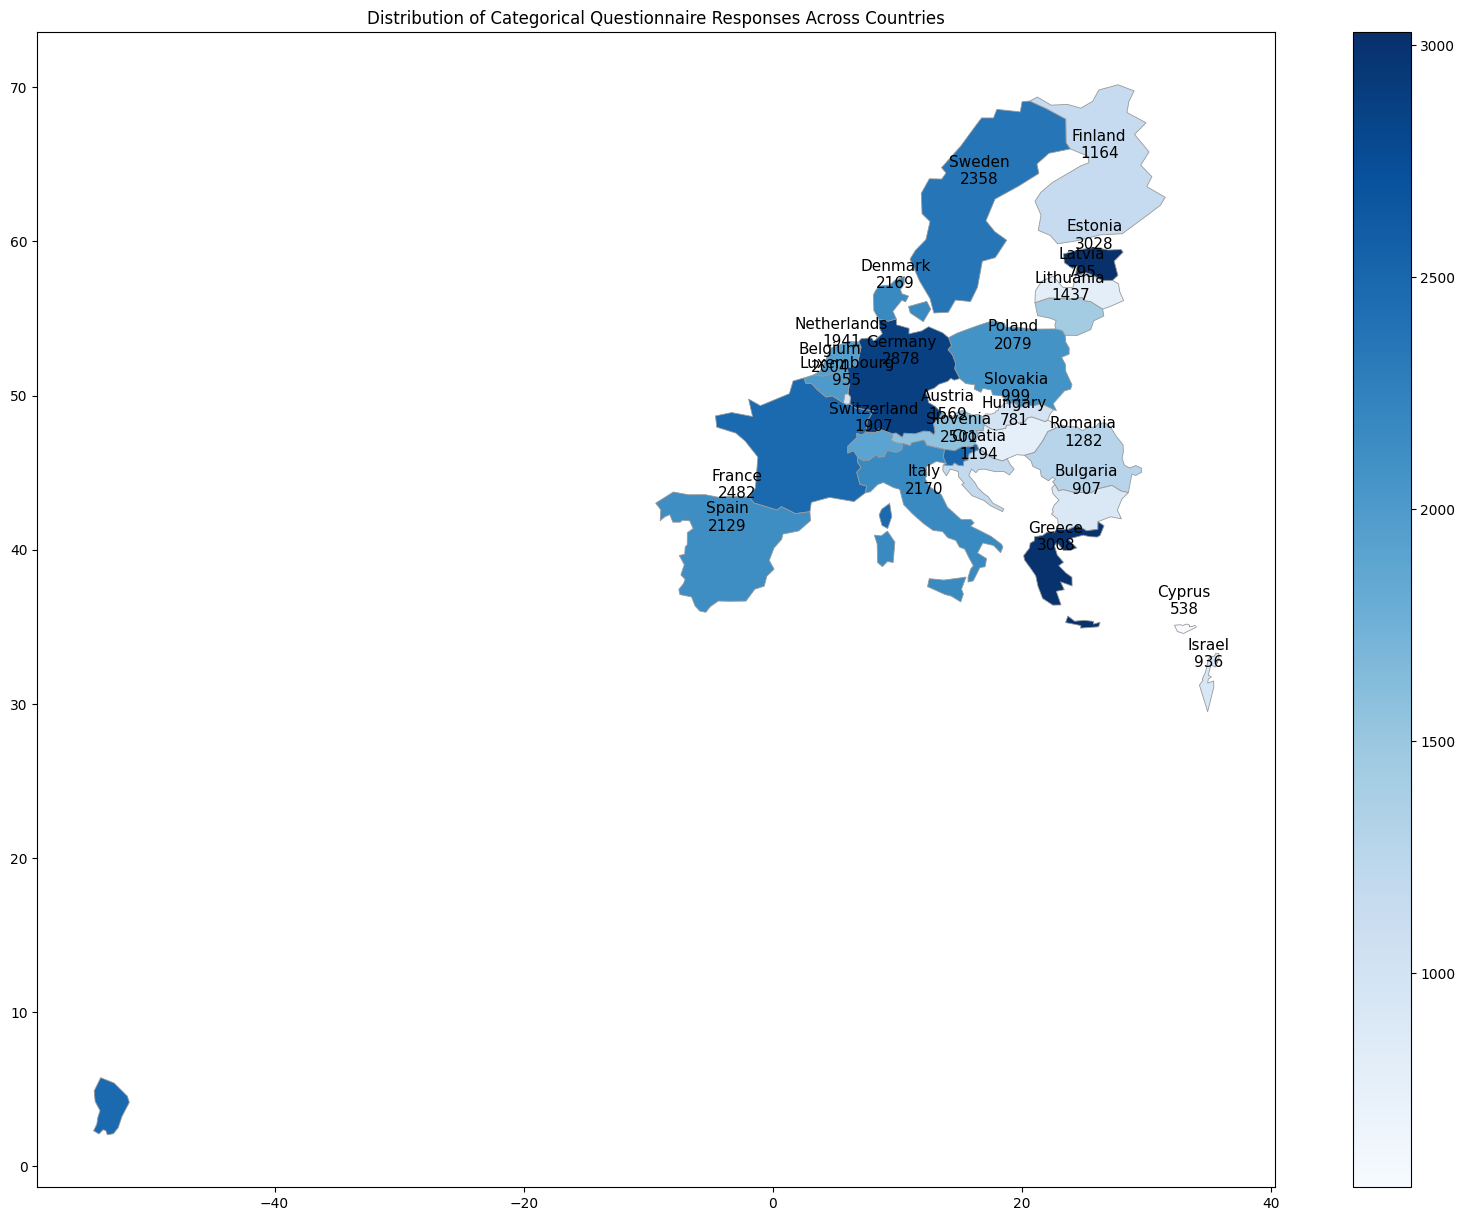

In [8]:
# Count occurrences of each country in the dataset
country_counts = df['country'].value_counts().reset_index()
country_counts.columns = ['name', 'count']

# Download 'naturalearth_lowres' data from Natural Earth
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter the world map to include only countries in your dataset
world = world[world['name'].isin(country_counts['name'])]

# Merge the filtered world map with the counts
merged = world.set_index('name').join(country_counts.set_index('name'))

# Plot the map with the counts
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
merged.plot(column='count', cmap='Blues', linewidth=0.6, ax=ax, edgecolor='0.6', legend=True)

# Display country names without overlap
for country, count in zip(country_counts['name'], country_counts['count']):
  if country not in['Czech Republic', 'Malta']:
    x, y = merged.loc[country, 'geometry'].centroid.x, merged.loc[country, 'geometry'].centroid.y
    plt.annotate(f'{country}\n{count}', (x, y), xytext=(0, 10), textcoords="offset points", ha='center', fontsize=11)

plt.title('Distribution of Categorical Questionnaire Responses Across Countries')
plt.show()

<ipython-input-9-c08a10dfc887>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age_int'] = pd.to_numeric(data['age_int'], errors='coerce')


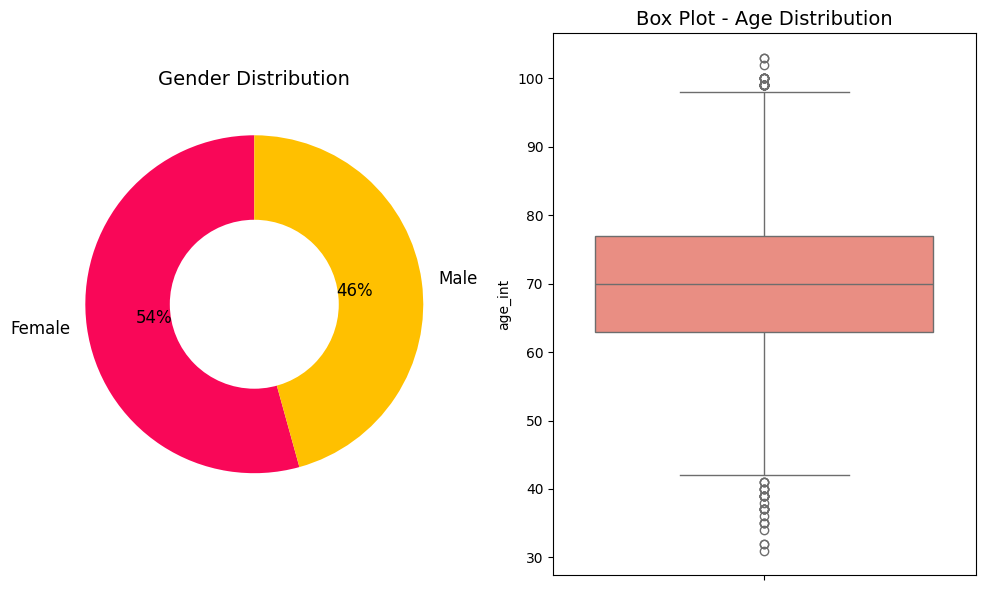

In [9]:
# Convert 'age_int' column to numeric
data['age_int'] = pd.to_numeric(data['age_int'], errors='coerce')
gender_counts = data['gender'].value_counts()

# Drop rows with missing values in 'age_int' column
data = data.dropna(subset=['age_int'])

plt.figure(figsize=(10, 6))

# Pie Chart
plt.subplot(1, 2, 1)
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.0f%%', startangle=90, colors=['#F90758','#FFC000'], textprops={'fontsize': 12})

# Draw circle
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Gender Distribution', fontsize=14)

# Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(y=data['age_int'], color='salmon')
plt.title('Box Plot - Age Distribution', fontsize=14)

plt.tight_layout()
plt.show()

In [10]:
# Calculate the percentage of missing values for each column
missing_percentage = (data.isnull().mean() * 100).round(2)

# Create a DataFrame to display the results
missing_df = pd.DataFrame({
    'Column': missing_percentage.index,
    'Missing Percentage': missing_percentage.values
})

# Sort the DataFrame by missing percentage in descending order
missing_df = missing_df.sort_values(by='Missing Percentage', ascending=False).reset_index(drop=True)
missing_df

,Column,Missing Percentage
0,ep129_13,100.00
1,ep130_25,100.00
2,ep129_26,100.00
3,ep130_10,100.00
4,ep130_11,100.00
...,...,...
795,ph005_,0.16
796,ph004_,0.16
797,ph003_,0.16
798,gender,0.00


In [11]:
# Delete the features with missing values percentages exceed the threshold
threshold_percentage = 50

# Identify columns with missing percentages greater than the threshold
columns_to_drop = missing_percentage[missing_percentage > threshold_percentage].index

# Drop columns with high missing percentages
data = data.drop(columns=columns_to_drop)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46733 entries, 0 to 46732
Columns: 226 entries, age_int to cf837_
dtypes: category(225), float64(1)
memory usage: 11.1 MB


In [12]:
# Drop duplicate rows and keep the first occurrence
data.drop_duplicates(inplace=True)

# Handle the missing values
# Iterate over each column
for column in data.columns:
    # Check if the column is categorical
    if data[column].dtype == 'category':
        # For categorical columns, fill missing values with the mode of the column
        data[column].fillna(data[column].mode()[0], inplace=True)
    else:
        # For numerical columns, fill missing values with the mean of the column
        data[column].fillna(data[column].mean(), inplace=True)

# Calculate the new percentage of missing values
missing_percentage = (data.isnull().mean() * 100).round(2)

# Create a DataFrame to display the results
missing_df = pd.DataFrame({
    'Column': missing_percentage.index,
    'Missing Percentage': missing_percentage.values
})

# Sort the DataFrame by missing percentage in descending order
missing_df = missing_df.sort_values(by='Missing Percentage', ascending=False).reset_index(drop=True)
missing_df

,Column,Missing Percentage
0,age_int,0.0
1,ep074_1,0.0
2,hc841d7,0.0
3,hc841dno,0.0
4,hc841dot,0.0
...,...,...
221,ph059d7,0.0
222,ph059d8,0.0
223,ph059d9,0.0
224,ph059d10,0.0


#Feature Engineering

In [13]:
value_mapping = {
'Yes': 1,
'No': 0,
'Poor': 1,
'Fair': 2,
'Good': 3,
'Very good': 4,
'Excellent': 5,
'Refusal': 6,
"Don't know": 7,
'Not limited': 0,
'Limited, but not severely': 1,
'Severely limited': 2,
'Selected': 1,
'Not selected': 0,
'Respondent only': 1,
'Proxy only': 2,
'Respondent and proxy': 3,
'Any hopes mentioned': 1,
'No hopes mentioned': 0,
'No such feelings': 0,
'Any mention of suicidal feelings or wish to b...': 1,
'Mentions guilt or self-blame but unclear': 1,
'Obvious excessive guilt or self-blame': 2,
'Trouble with sleep or recent change in pattern': 1,
'No trouble sleeping': 0,
'No mention of loss of interest': 0,
'Less interest than usual mentioned': 1,
'Non-specific or uncodeable response': 2,
'No diminution in desire for food': 0,
'Diminution in desire for food': 1,
'No such difficulty mentioned': 0,
'Difficulty in concentrating': 1,
'Mentions any enjoyment from activity': 1,
'Fails to mention any enjoyable activity': 0,
'Respondent': 1,
'Section not answered (proxy interview)': 0,
'Hardly ever or never': 0,
'Some of the time': 1,
'Often': 2,
'Yes, temporarily': 1,
'Yes, permanently': 2,
'Somewhat satisfied': 3,
'Somewhat dissatisfied': 2,
'Very satisfied': 4,
'Very dissatisfied': 1,
'Sometimes': 2,
'Never': 0,
'Always': 3,
'Rarely': 1,
'Retired': 0,
'Homemaker': 2,
'Other': 9,
'Employed or self-employed (including working ...,': 1,
'Unemployed': 4,
'Permanently sick or disabled': 3,
'Calendar month/4 weeks': 3,
'One week': 1,
'Full year/12 months/52 weeks': 6,
'Three months/13 weeks': 4,
'Six months/26 weeks': 5,
'Two weeks' : 2,
'Given correctly': 1,
"Given incorrectly/doesn't know": 0,
'Same': 2,
'Worse': 1,
'Better': 3,
'Continue': 1,
'Correct': 1,
'Incorrect': 0,
'Wants to start over': 1,
'Correctly described': 1,
'Not correct': 0,
'Fully correct copy': 2,
'Incorrect copy': 0,
'Drawing is impossible due to physical reasons': 0,
'Partially correct copy': 1,
}

In [14]:
# Apply mapping to the entire DataFrame
data = data.applymap(lambda x: value_mapping.get(x, x))

# The following features were deleted since it is assumed that they do no contain relevant information
data = data.drop(columns=["ft021_", "ep210_", "ph054_", "hc602_",  "hc876_",  "hc877_",  "ep078e_1",  "ep208_1",  "cf010_",  "cf108_",  "cf109_",  "cf110_",  "cf111_",  "cf112_"], axis=1)
data = data.drop(["cf820_", "cf832_", "cf833_", "cf836_"], axis=1)
# Convert categorical features to numbers so they can be digested by ML models
data = pd.get_dummies(data, columns=data.select_dtypes(include=['object']).columns)

data.head(3)

,age_int,ph003_,ph004_,ph005_,ph006d1,ph006d2,ph006d3,ph006d4,ph006d5,ph006d6,...,mh004__7,mh004__Any mention of suicidal feelings or wish to be dead,ep005__0,ep005__2,ep005__3,ep005__4,ep005__6,ep005__7,ep005__9,ep005__Employed or self-employed (including working for family business)
0,80.0,2,1,2,1,1,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,68.0,3,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,68.0,4,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [15]:
data["cf018_"] = data["cf018d1"].apply(lambda x: 0 if x == 0 else 1)
data = data.drop(["cf018d1","cf018d2","cf018d3","cf018d4"], axis=1)

#Correlation Analysis

In [16]:
# First the description of each feature is uploaded to facilitate the reading of the association output
feature_description_df = pd.read_excel('/content/drive/MyDrive/SHAREw8/labels.xlsx')

# Create a dictionary mapping feature names to descriptions
feature_description_mapping = dict(zip(feature_description_df['Variable Name'], feature_description_df['Variable Label']))

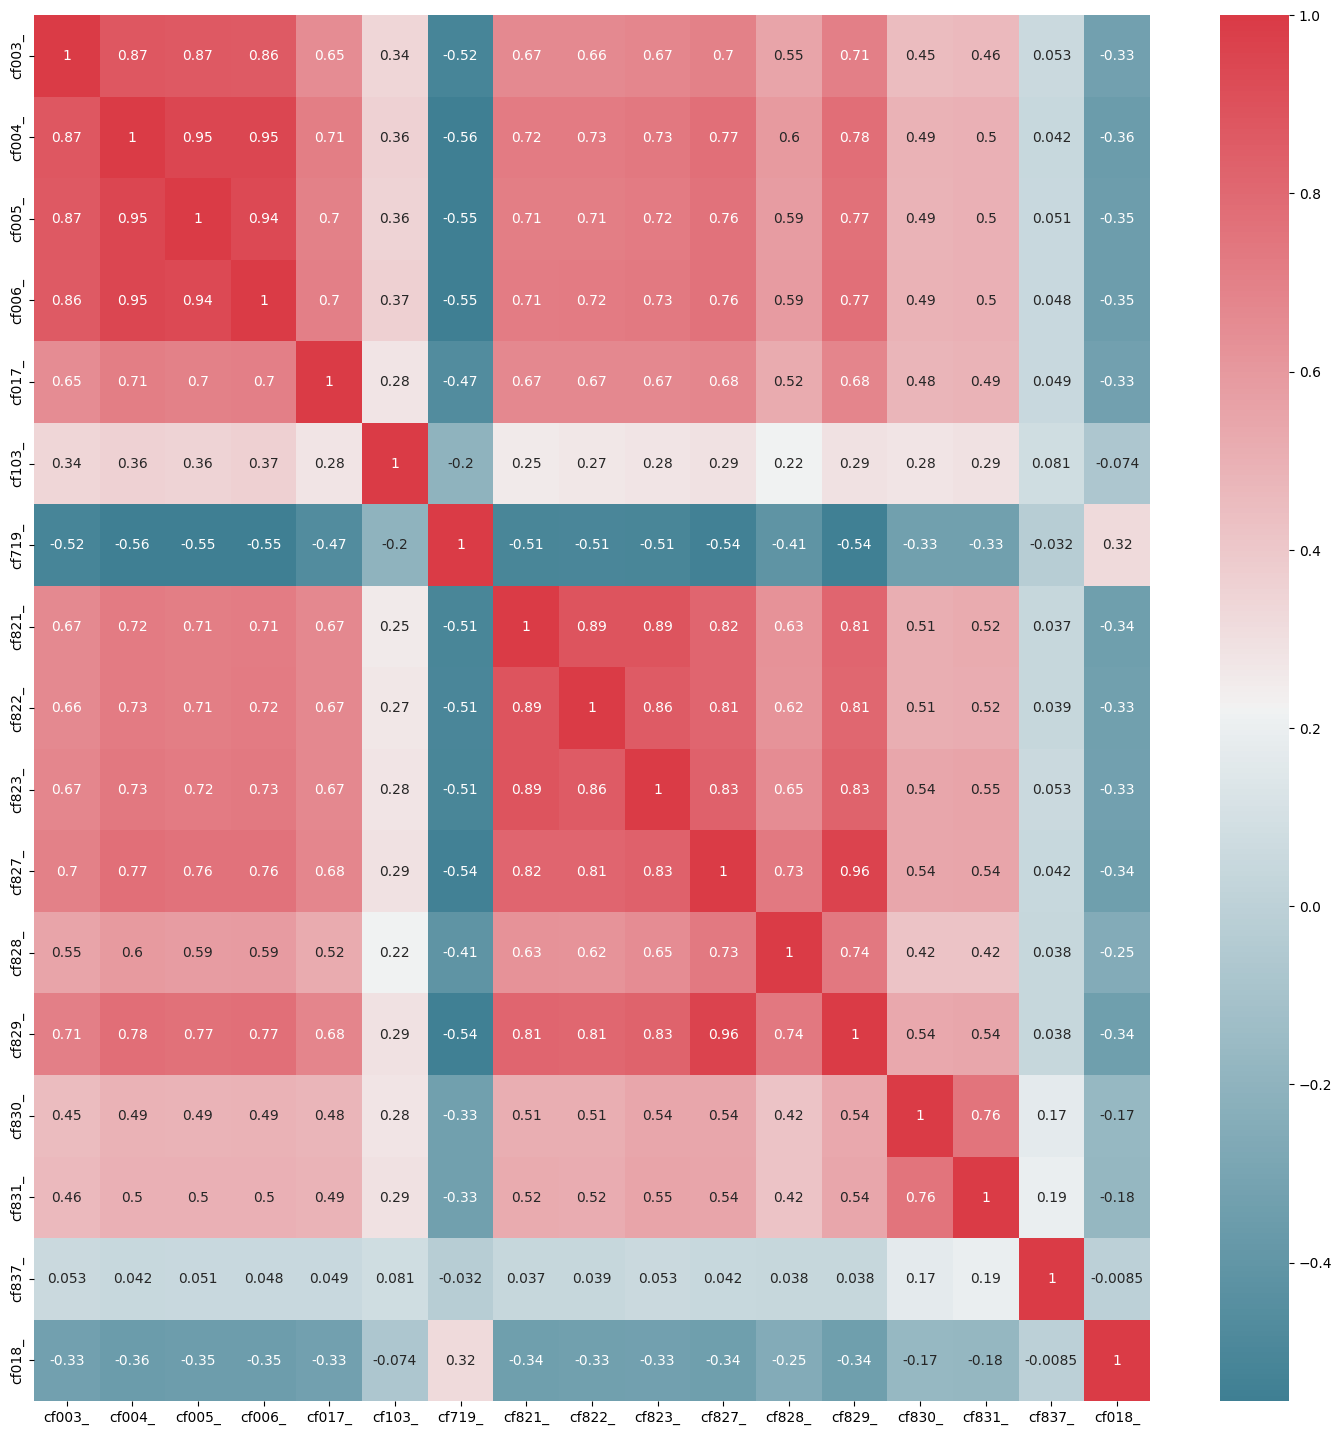

In [17]:
# Visualize the correlation between cognitive features
# Get all columns that start with prefixes "cf"
selected_columns = data.filter(regex='^cf', axis=1)

# Combine selected columns with their names
cognitive_data = data[selected_columns.columns.tolist()]

correlation_matrix = cognitive_data.corr()

_,ax=plt.subplots(figsize=(18,18))
colormap=sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(correlation_matrix,annot=True,cmap=colormap)

# Set the correlation threshold
threshold = 0.7

# Find features with correlation above the threshold
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            feature_pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            high_corr_pairs.append(feature_pair)

# Display features with correlation exceeding the threshold
# print("Feature pairs with correlation > 0.7:")
# for feature_pair in high_corr_pairs:
#     description_i = feature_description_mapping.get(feature_pair[0], feature_pair[0])
#     description_j = feature_description_mapping.get(feature_pair[1], feature_pair[1])
#     print(f"Features: {description_i} ({feature_pair[0]}) and {description_j} ({feature_pair[1]}), Correlation Measure: {correlation_matrix.loc[feature_pair[0], feature_pair[1]]:.2f}")

In [18]:
# Delete the features with strong assosciation
data = data.drop(["cf004_", "cf005_", "cf006_", "cf821_", "cf822_", "cf823_", "cf827_", "cf828_", "cf829_", "cf830_"], axis=1)


Feature pairs with correlation > 0.7:


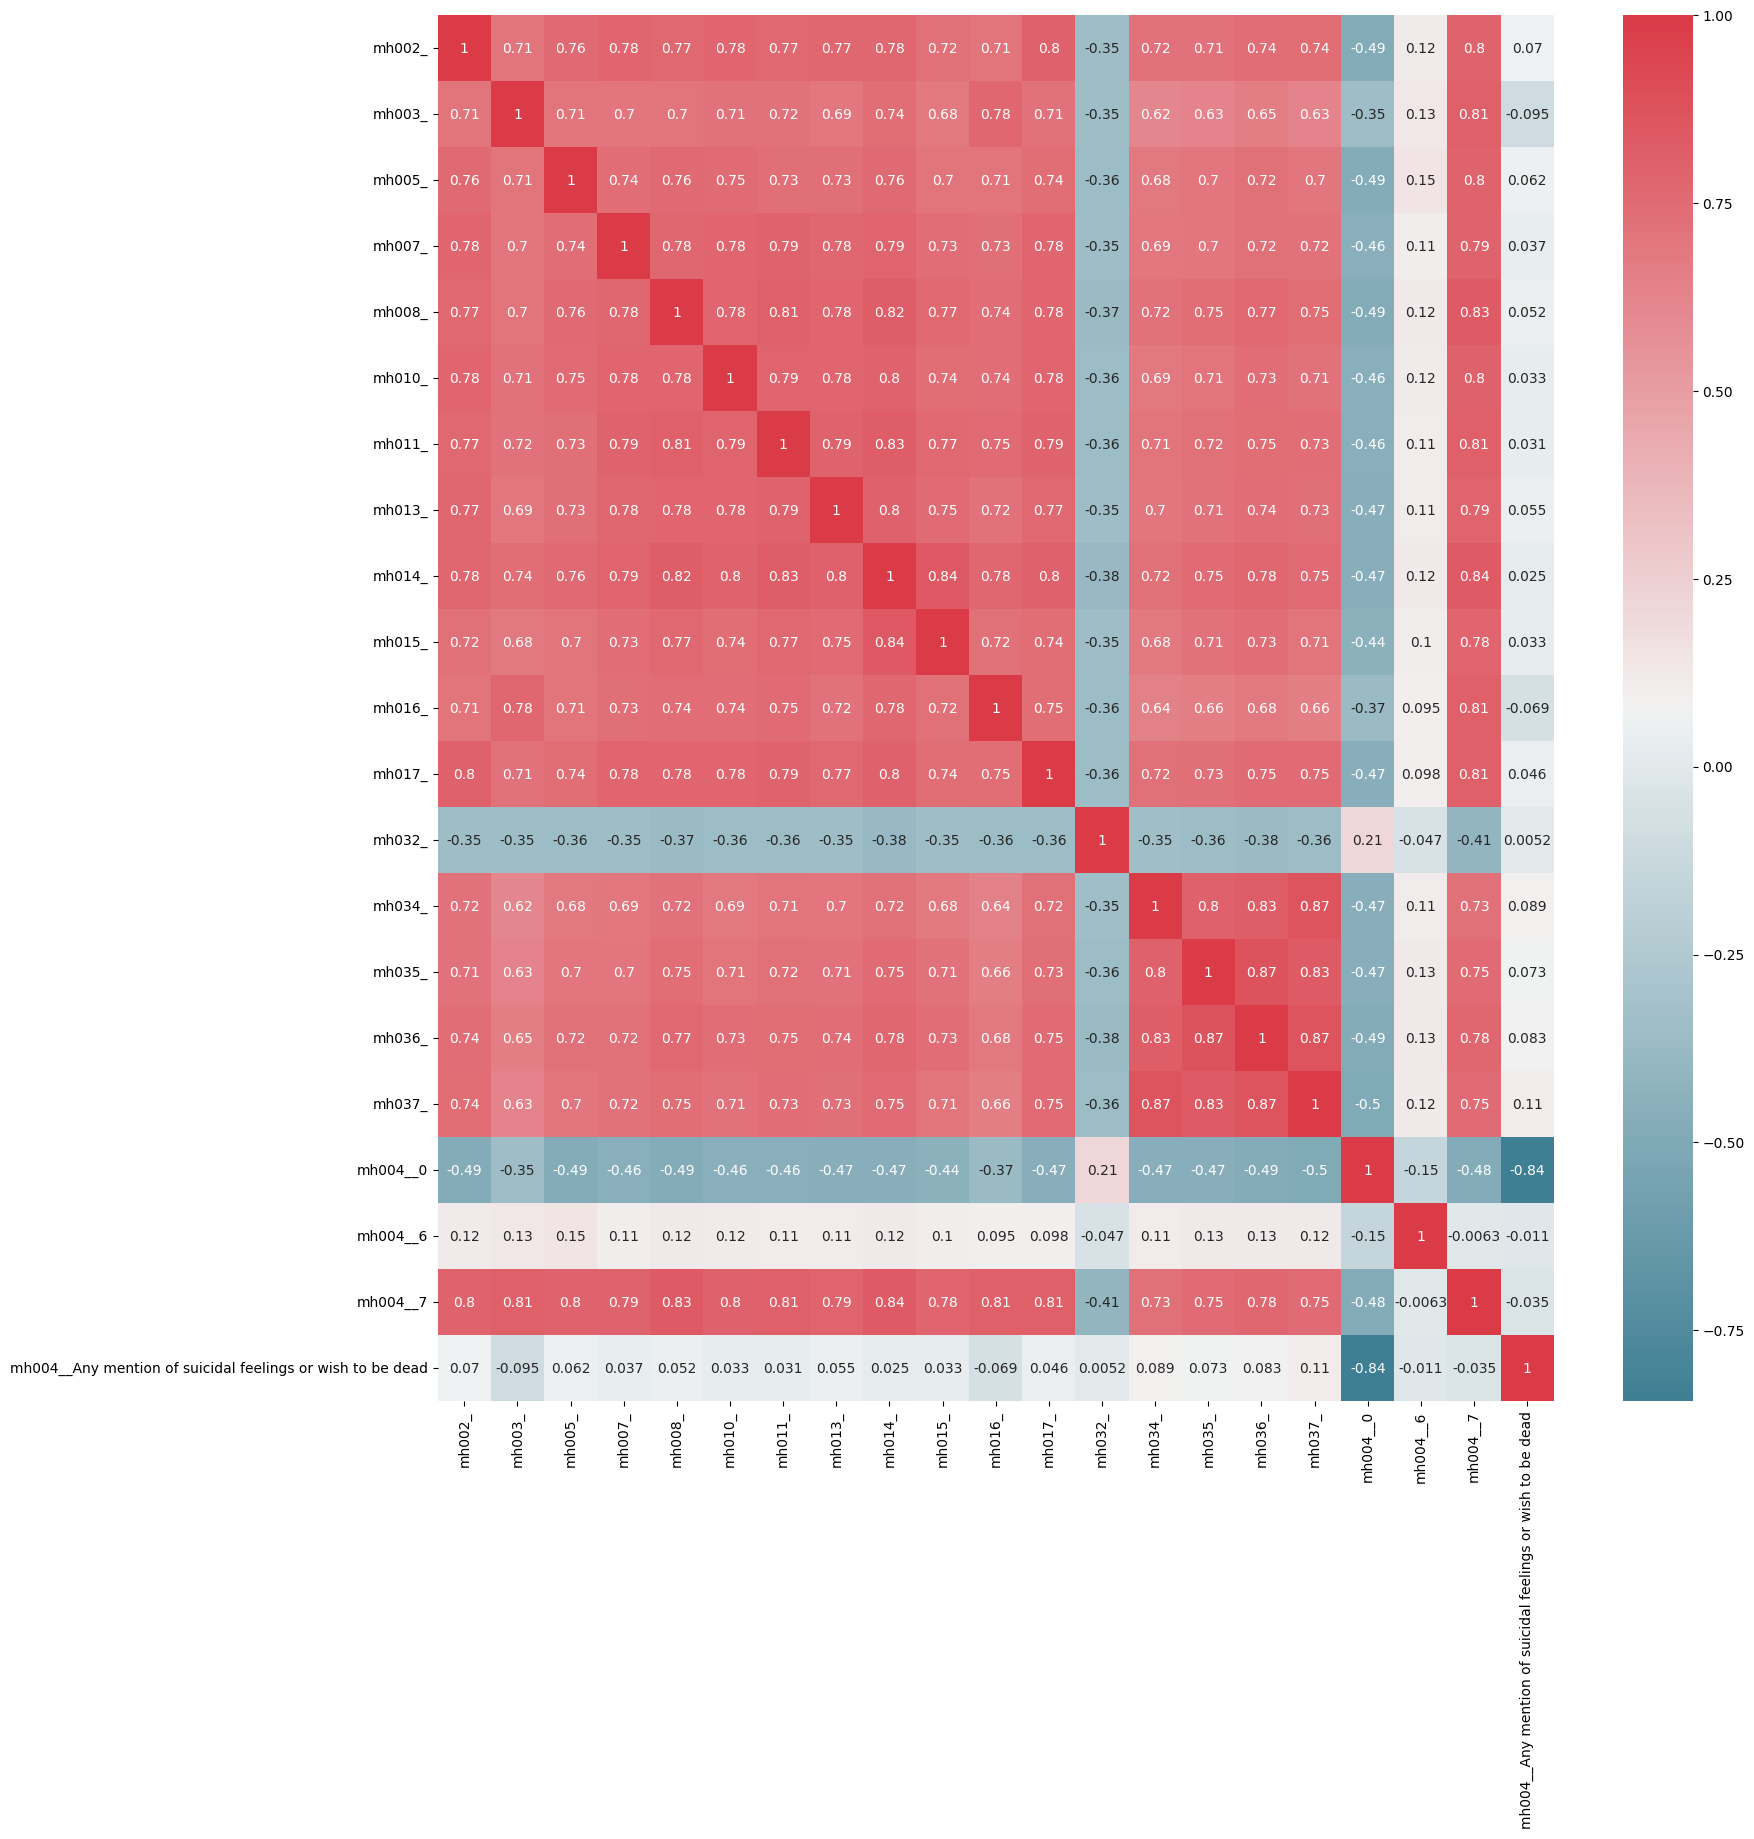

In [19]:
# Visualize the correlation between mental health features
# Get all columns that start with prefixes "mh"
selected_columns = data.filter(regex='^mh', axis=1)

# Combine selected columns with their names
mental_data = data[selected_columns.columns.tolist()]

correlation_matrix = mental_data.corr()

_,ax=plt.subplots(figsize=(18,18))
colormap=sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(correlation_matrix,annot=True,cmap=colormap)

# Set the correlation threshold
threshold = 0.7

# Find features with correlation above the threshold
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            feature_pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            high_corr_pairs.append(feature_pair)

# Display features with correlation exceeding the threshold
print("Feature pairs with correlation > 0.7:")
# for feature_pair in high_corr_pairs:
#     description_i = feature_description_mapping.get(feature_pair[0], feature_pair[0])
#     description_j = feature_description_mapping.get(feature_pair[1], feature_pair[1])
#     print(f"Features: {description_i} ({feature_pair[0]}) and {description_j} ({feature_pair[1]}), Correlation Measure: {correlation_matrix.loc[feature_pair[0], feature_pair[1]]:.2f}")

In [20]:
# Delete the features with strong assosciation
data = data.drop(["mh002_", "mh003_", "mh005_", "mh007_", "mh008_", "mh010_", "mh011_", "mh013_", "mh014_", "mh015_", "mh016_", "mh017_", "mh034_", "mh035_", "mh036_", "mh037_","mh004__0"], axis=1)
data = data.drop(["mh032_", "mh004__6", "cf719_"], axis=1)


In [21]:
# Extract the output features
selected_columns = data.filter(regex='^(mh|cf)', axis=1).columns
X = data.drop(selected_columns, axis=1)
y = data["mh004__Any mention of suicidal feelings or wish to be dead"]

X.head(3)

,age_int,ph003_,ph004_,ph005_,ph006d1,ph006d2,ph006d3,ph006d4,ph006d5,ph006d6,...,gender_Female,gender_Male,ep005__0,ep005__2,ep005__3,ep005__4,ep005__6,ep005__7,ep005__9,ep005__Employed or self-employed (including working for family business)
0,80.0,2,1,2,1,1,1,1,0,0,...,1,0,1,0,0,0,0,0,0,0
1,68.0,3,0,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,68.0,4,0,0,0,1,1,0,0,0,...,0,1,1,0,0,0,0,0,0,0


In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46707 entries, 0 to 46732
Columns: 178 entries, age_int to ep005__Employed or self-employed (including working for family business)
dtypes: float64(2), int64(166), uint8(10)
memory usage: 60.7 MB


In [23]:
y.info()

<class 'pandas.core.series.Series'>
Int64Index: 46707 entries, 0 to 46732
Series name: mh004__Any mention of suicidal feelings or wish to be dead
Non-Null Count  Dtype
--------------  -----
46707 non-null  uint8
dtypes: uint8(1)
memory usage: 410.5 KB


In [24]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)


label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [25]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers

In [26]:
import os
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
import glob
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
%matplotlib inline

# Loading ADNI dataset

In [27]:
data2 = pd.read_csv("/content/drive/MyDrive/ADNIMERGE_11Dec2023.csv")
data2.head()

,RID,COLPROT,ORIGPROT,PTID,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,...,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,FBB_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,ADNI1,ADNI1,011_S_0002,11,bl,2005-09-08,CN,74.3,Male,...,NaN,1.33615,NaN,NaN,NaN,0.000000,0.00000,0,0,2023-07-07 04:59:40.0
1,3,ADNI1,ADNI1,011_S_0003,11,bl,2005-09-12,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,0.000000,0.00000,0,0,2023-07-07 04:59:40.0
2,3,ADNI1,ADNI1,011_S_0003,11,m06,2006-03-13,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,0.498289,5.96721,6,6,2023-07-07 04:59:40.0
3,3,ADNI1,ADNI1,011_S_0003,11,m12,2006-09-12,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,0.999316,11.96720,12,12,2023-07-07 04:59:40.0
4,3,ADNI1,ADNI1,011_S_0003,11,m24,2007-09-12,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,1.998630,23.93440,24,24,2023-07-07 04:59:40.0


In [28]:
# Store the names of selected columns
selected_column_names = ["AGE", "PTGENDER", "PTEDUCAT", "APOE4", "FDG", "PIB", "AV45", "FBB", "MMSE", "RAVLT_immediate", "RAVLT_learning", "RAVLT_forgetting", "RAVLT_perc_forgetting", "DX"]

# Combine selected columns with their names
data2 = data2[selected_column_names]

data2.head()

,AGE,PTGENDER,PTEDUCAT,APOE4,FDG,PIB,AV45,FBB,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,DX
0,74.3,Male,16,0.0,1.33615,NaN,NaN,NaN,28.0,44.0,4.0,6.0,54.5455,CN
1,81.3,Male,18,1.0,1.10860,NaN,NaN,NaN,20.0,22.0,1.0,4.0,100.0000,Dementia
2,81.3,Male,18,1.0,1.07796,NaN,NaN,NaN,24.0,19.0,2.0,6.0,100.0000,Dementia
3,81.3,Male,18,1.0,1.11626,NaN,NaN,NaN,17.0,31.0,2.0,7.0,100.0000,Dementia
4,81.3,Male,18,1.0,1.06134,NaN,NaN,NaN,19.0,23.0,1.0,5.0,100.0000,Dementia


In [29]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16421 entries, 0 to 16420
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AGE                    16412 non-null  float64
 1   PTGENDER               16421 non-null  object 
 2   PTEDUCAT               16421 non-null  int64  
 3   APOE4                  16056 non-null  float64
 4   FDG                    3693 non-null   float64
 5   PIB                    223 non-null    float64
 6   AV45                   3080 non-null   float64
 7   FBB                    513 non-null    float64
 8   MMSE                   11469 non-null  float64
 9   RAVLT_immediate        11346 non-null  float64
 10  RAVLT_learning         11347 non-null  float64
 11  RAVLT_forgetting       11315 non-null  float64
 12  RAVLT_perc_forgetting  11242 non-null  float64
 13  DX                     11458 non-null  object 
dtypes: float64(11), int64(1), object(2)
memory usage: 1.8+

In [30]:
# Calculate the percentage of missing values for each column
missing_percentage2 = (data2.isnull().mean() * 100).round(2)

# Create a DataFrame to display the results
missing_df2 = pd.DataFrame({
    'Column': missing_percentage2.index,
    'Missing Percentage': missing_percentage2.values
})

# Sort the DataFrame by missing percentage in descending order
missing_df2 = missing_df2.sort_values(by='Missing Percentage', ascending=False).reset_index(drop=True)
missing_df2

,Column,Missing Percentage
0,PIB,98.64
1,FBB,96.88
2,AV45,81.24
3,FDG,77.51
4,RAVLT_perc_forgetting,31.54
5,RAVLT_forgetting,31.09
6,RAVLT_immediate,30.91
7,RAVLT_learning,30.90
8,DX,30.22
9,MMSE,30.16


In [31]:
# Delete the features with missing values percentages exceed the threshold
threshold_percentage2 = 50

# Identify columns with missing percentages greater than the threshold
columns_to_drop2 = missing_percentage[missing_percentage > threshold_percentage2].index

# Drop columns with high missing percentages
data2 = data2.drop(columns=columns_to_drop2)

data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16421 entries, 0 to 16420
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AGE                    16412 non-null  float64
 1   PTGENDER               16421 non-null  object 
 2   PTEDUCAT               16421 non-null  int64  
 3   APOE4                  16056 non-null  float64
 4   FDG                    3693 non-null   float64
 5   PIB                    223 non-null    float64
 6   AV45                   3080 non-null   float64
 7   FBB                    513 non-null    float64
 8   MMSE                   11469 non-null  float64
 9   RAVLT_immediate        11346 non-null  float64
 10  RAVLT_learning         11347 non-null  float64
 11  RAVLT_forgetting       11315 non-null  float64
 12  RAVLT_perc_forgetting  11242 non-null  float64
 13  DX                     11458 non-null  object 
dtypes: float64(11), int64(1), object(2)
memory usage: 1.8+

In [32]:
# Drop duplicate rows and keep the first occurrence
data2.drop_duplicates(inplace=True)

# Handle the missing values
# Iterate over each column
for column in data2.columns:
    # Check if the column is categorical
    if data2[column].dtype == 'object':
        # For categorical columns, fill missing values with the mode of the column
        data2[column].fillna(data2[column].mode()[0], inplace=True)
    else:
        # For numerical columns, fill missing values with the mean of the column
        data2[column].fillna(data2[column].mean(), inplace=True)

# Calculate the new percentage of missing values
missing_percentage2 = (data2.isnull().mean() * 100).round(2)

# Create a DataFrame to display the results
missing_df2 = pd.DataFrame({
    'Column': missing_percentage2.index,
    'Missing Percentage': missing_percentage2.values
})

# Sort the DataFrame by missing percentage in descending order
missing_df2 = missing_df2.sort_values(by='Missing Percentage', ascending=False).reset_index(drop=True)
missing_df2

,Column,Missing Percentage
0,AGE,0.0
1,PTGENDER,0.0
2,PTEDUCAT,0.0
3,APOE4,0.0
4,FDG,0.0
5,PIB,0.0
6,AV45,0.0
7,FBB,0.0
8,MMSE,0.0
9,RAVLT_immediate,0.0


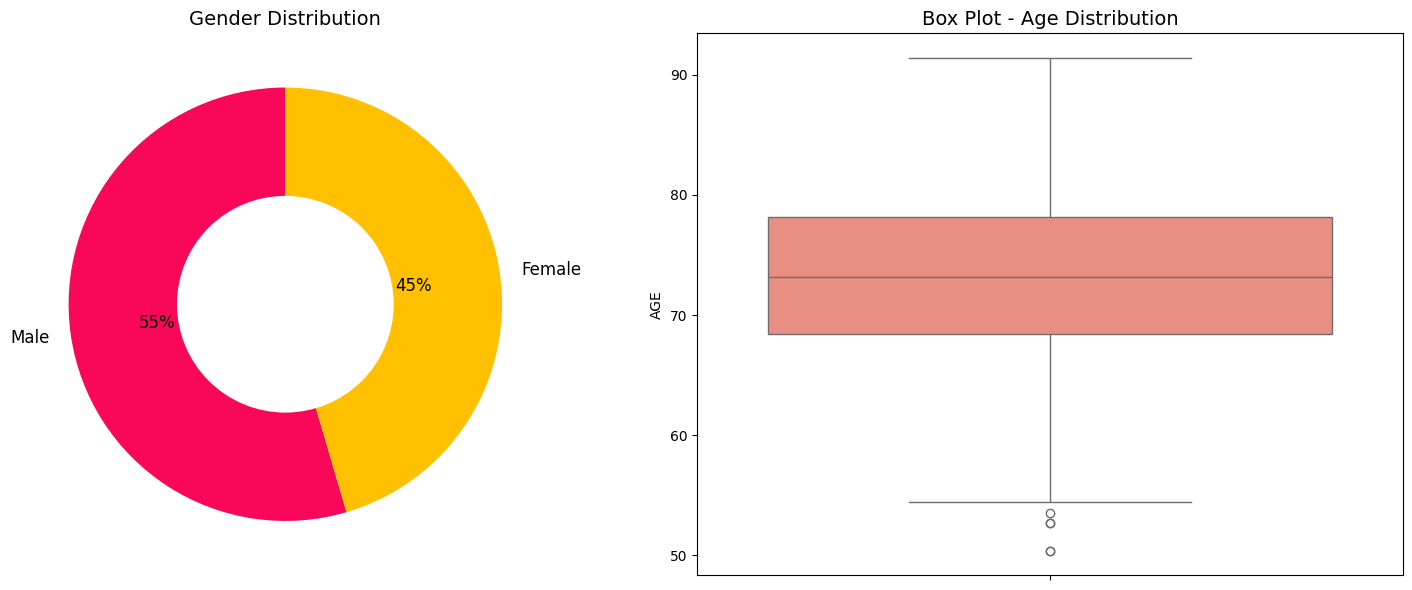

In [33]:
# Convert 'Age' column to numeric
data2['AGE'] = pd.to_numeric(data2['AGE'], errors='coerce')
gender_counts2 = data2['PTGENDER'].value_counts()

# Drop rows with missing values in 'Age' column
data2 = data2.dropna(subset=['AGE'])

plt.figure(figsize=(15, 6))

# Pie Chart
plt.subplot(1, 2, 1)
plt.pie(gender_counts2, labels=gender_counts2.index, autopct='%1.0f%%', startangle=90, colors=['#F90758','#FFC000'], textprops={'fontsize': 12})

# Draw circle
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Gender Distribution', fontsize=14)

# Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(y=data2['AGE'], color='salmon')
plt.title('Box Plot - Age Distribution', fontsize=14)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Pie Chart of DX')

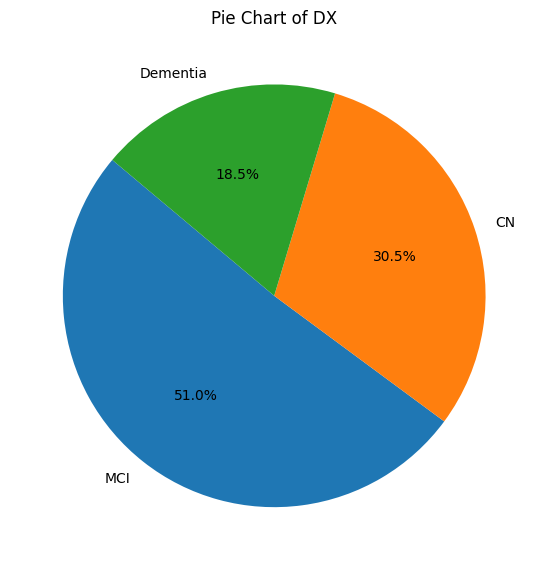

In [34]:
# Count the occurrences of each unique value in the column
value_counts1 = data2["DX"].value_counts()

plt.figure(figsize=(15, 10))

# Pie Chart
plt.subplot(1, 2, 1)
plt.pie(value_counts1, labels=value_counts1.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Pie Chart of {"DX"}')

Feature pairs with correlation > 0.75:
Features: RAVLT_forgetting and RAVLT_perc_forgetting, Correlation Measure: 0.72


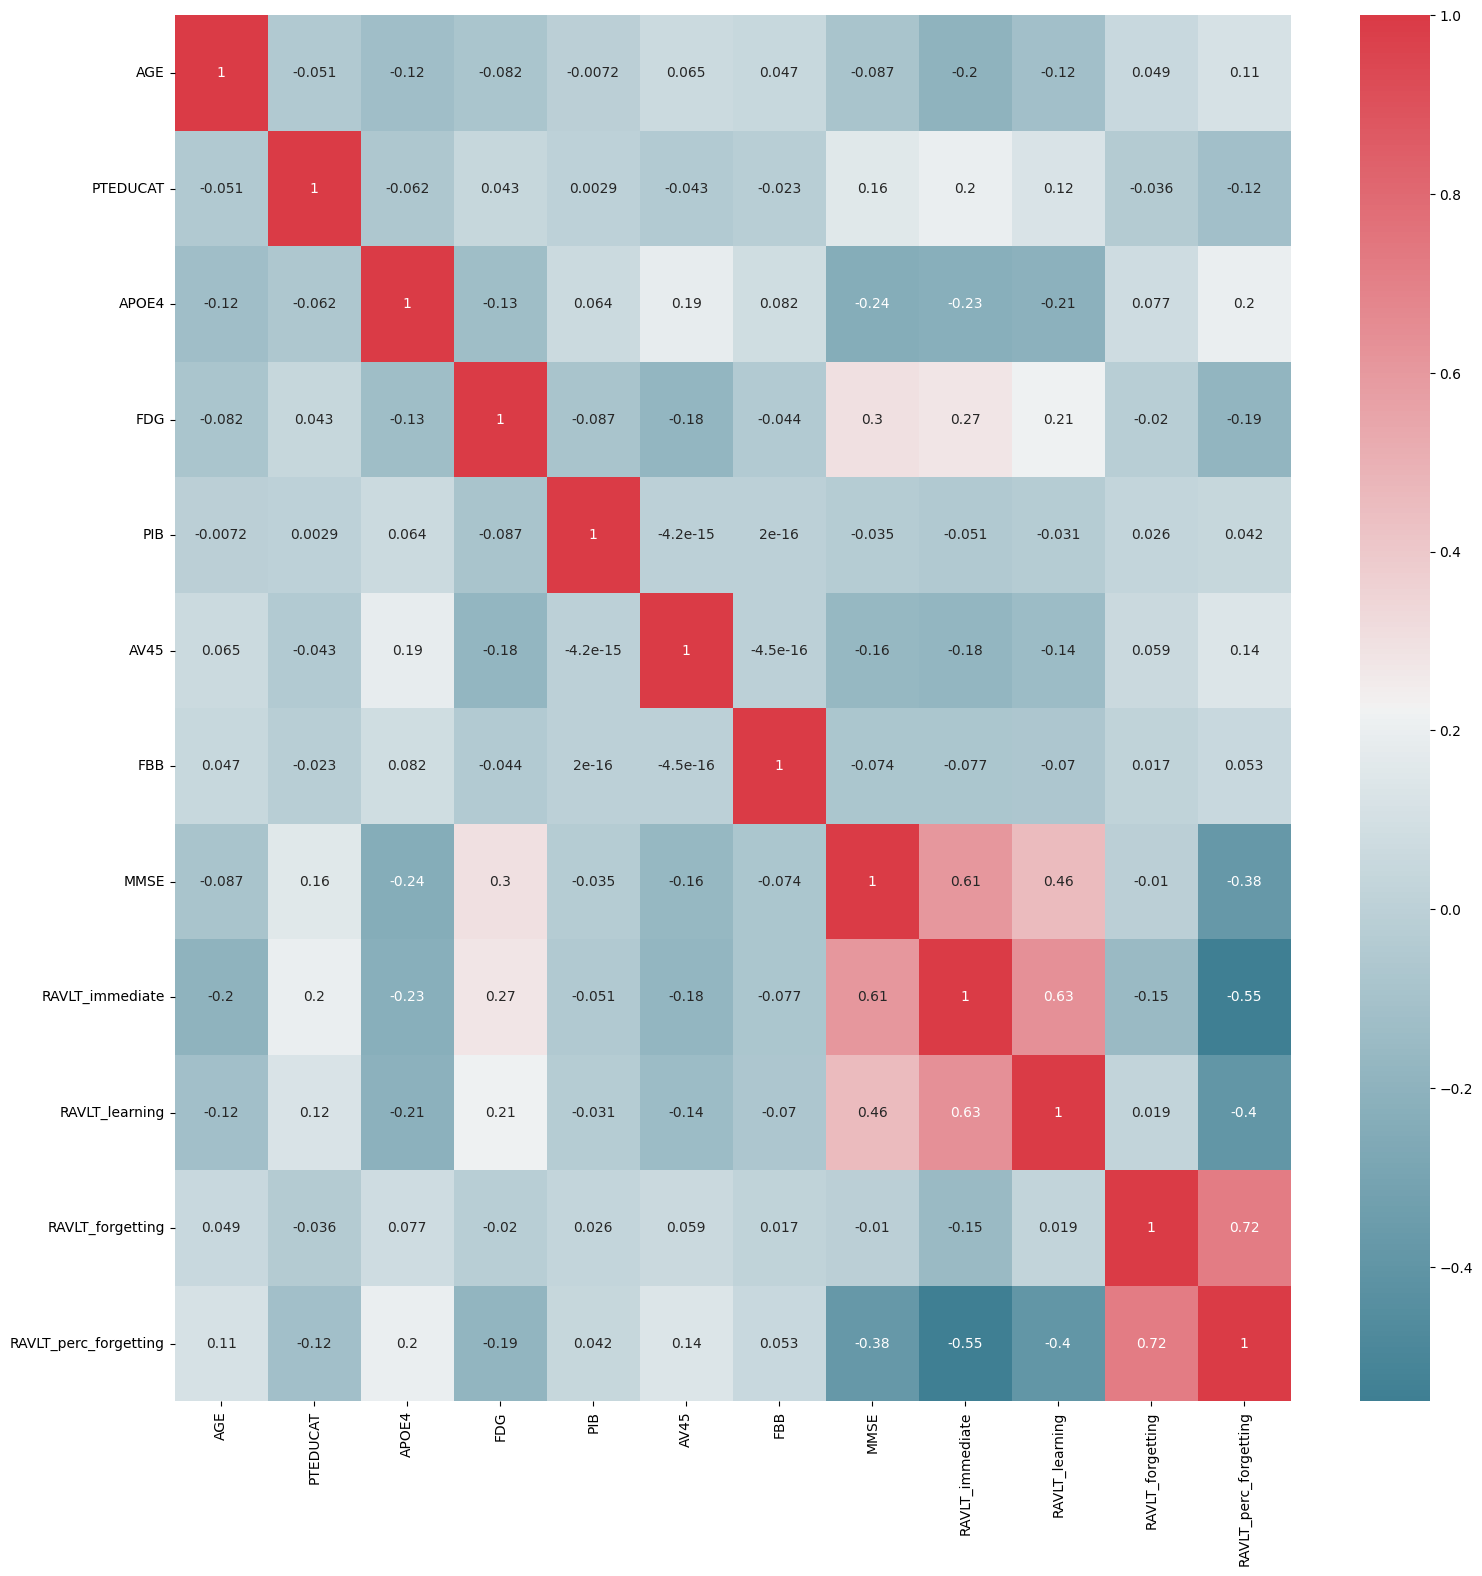

In [35]:
# Visualize the correlation between features

correlation_matrix2 = data2.corr()

_,ax=plt.subplots(figsize=(18,18))
colormap=sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(correlation_matrix2,annot=True,cmap=colormap)

# Set the correlation threshold
threshold = 0.7

# Find features with correlation above the threshold
high_corr_pairs2 = []

for i in range(len(correlation_matrix2.columns)):
    for j in range(i + 1, len(correlation_matrix2.columns)):
        if abs(correlation_matrix2.iloc[i, j]) > threshold:
            feature_pair = (correlation_matrix2.columns[i], correlation_matrix2.columns[j])
            high_corr_pairs2.append(feature_pair)

# Display features with correlation exceeding the threshold
print("Feature pairs with correlation > 0.75:")
for feature_pair in high_corr_pairs2:
    print(f"Features: {feature_pair[0]} and {feature_pair[1]}, Correlation Measure: {correlation_matrix2.loc[feature_pair[0], feature_pair[1]]:.2f}")

In [36]:
# Separate the Targets from the Inputs (Inputs: "AGE", "PTGENDER", "PTEDUCAT", "APOE4", "MMSE", "RAVLT_immediate", "RAVLT_learning", "RAVLT_forgetting", "RAVLT_perc_forgetting", Outputs: "DX")

X1 = data2[["AGE", "PTGENDER", "PTEDUCAT", "APOE4",  "MMSE", "RAVLT_immediate", "RAVLT_learning", "RAVLT_forgetting", "RAVLT_perc_forgetting"]]
y1 = data2["DX"]

X1.head(3)

,AGE,PTGENDER,PTEDUCAT,APOE4,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting
0,74.3,Male,16,0.0,28.0,44.0,4.0,6.0,54.5455
1,81.3,Male,18,1.0,20.0,22.0,1.0,4.0,100.0000
2,81.3,Male,18,1.0,24.0,19.0,2.0,6.0,100.0000


In [37]:
# Convert categorical features to numbers so they can be digested by ML models : Apply one-hot encoding: This will create two columns for the gender feature ['Female', 'Male']
X1 = pd.get_dummies(X1, columns=X1.select_dtypes(include=['object']).columns)
# Convert the AGE column to integers
X1['AGE'] = X1['AGE'].astype(int)

In [38]:
X1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13173 entries, 0 to 16413
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AGE                    13173 non-null  int64  
 1   PTEDUCAT               13173 non-null  int64  
 2   APOE4                  13173 non-null  float64
 3   MMSE                   13173 non-null  float64
 4   RAVLT_immediate        13173 non-null  float64
 5   RAVLT_learning         13173 non-null  float64
 6   RAVLT_forgetting       13173 non-null  float64
 7   RAVLT_perc_forgetting  13173 non-null  float64
 8   PTGENDER_Female        13173 non-null  uint8  
 9   PTGENDER_Male          13173 non-null  uint8  
dtypes: float64(6), int64(2), uint8(2)
memory usage: 952.0 KB


In [39]:

X2_train, X2_test, y2_train, y2_test = train_test_split(X1, y1, test_size=0.2, random_state=3)

label_encoder2 = LabelEncoder()
y2_train_encoded = label_encoder2.fit_transform(y2_train)
print("Classes: ", label_encoder2.classes_)
y2_test_encoded = label_encoder2.transform(y2_test)

Classes:  ['CN' 'Dementia' 'MCI']


In [40]:
from tensorflow.keras.utils import to_categorical

y2_train_onehot = to_categorical(y2_train_encoded, num_classes= 3)

y2_test_onehot = to_categorical(y2_test_encoded, num_classes= 3)


# Building Neural network to train on SHAREw8

In [41]:
# SHAREw8 Neural Network
SHAREw8_NNmodel = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(178,)),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


SHAREw8_NNmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
SHAREw8_NNmodel.fit(X_train, y_train_encoded, epochs=5, batch_size=32, validation_data=(X_test, y_test_encoded))

# Save the learned weights to use for transfer learning
SHAREw8_NNmodel.save_weights('final06_SHAREw8_NNmodel_weights.h5')

Epoch 1/5
1168/1168 [==============================] - 4s 3ms/step - loss: 0.3229 - accuracy: 0.9331 - val_loss: 0.2330 - val_accuracy: 0.9365
Epoch 2/5
1168/1168 [==============================] - 3s 3ms/step - loss: 0.2290 - accuracy: 0.9424 - val_loss: 0.2195 - val_accuracy: 0.9365
Epoch 3/5
1168/1168 [==============================] - 3s 3ms/step - loss: 0.2154 - accuracy: 0.9424 - val_loss: 0.2142 - val_accuracy: 0.9365
Epoch 4/5
1168/1168 [==============================] - 4s 3ms/step - loss: 0.2091 - accuracy: 0.9424 - val_loss: 0.2116 - val_accuracy: 0.9365
Epoch 5/5
1168/1168 [==============================] - 3s 3ms/step - loss: 0.2088 - accuracy: 0.9424 - val_loss: 0.2157 - val_accuracy: 0.9365


# Building Neural Network with transfer learning (SHAREw8-to-ADNI)

In [52]:
# Transfer ADNI Neural Network
Transfer_ADNI_NNmodel = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(10,)),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

# Load the learned weights from the SHAREw8 neural network model into the corresponding layers of transfer ADNI model to use for transfer learning
# Transfer learning
Transfer_ADNI_NNmodel.load_weights('final06_SHAREw8_NNmodel_weights.h5', by_name=True)

Transfer_ADNI_NNmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [53]:
# Train Model
Transfer_ADNI_NNmodel.fit(X2_train, y2_train_onehot, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
264/264 [==============================] - 2s 3ms/step - loss: 4.0222 - accuracy: 0.3822 - val_loss: 1.0083 - val_accuracy: 0.5427
Epoch 2/20
264/264 [==============================] - 1s 3ms/step - loss: 1.2514 - accuracy: 0.4903 - val_loss: 0.9976 - val_accuracy: 0.5218
Epoch 3/20
264/264 [==============================] - 1s 3ms/step - loss: 1.0963 - accuracy: 0.5224 - val_loss: 0.9586 - val_accuracy: 0.5218
Epoch 4/20
264/264 [==============================] - 1s 3ms/step - loss: 1.0214 - accuracy: 0.5346 - val_loss: 0.9430 - val_accuracy: 0.5218
Epoch 5/20
264/264 [==============================] - 1s 3ms/step - loss: 0.9932 - accuracy: 0.5402 - val_loss: 0.9144 - val_accuracy: 0.5223
Epoch 6/20
264/264 [==============================] - 1s 3ms/step - loss: 0.9611 - accuracy: 0.5471 - val_loss: 0.8824 - val_accuracy: 0.5237
Epoch 7/20
264/264 [==============================] - 1s 4ms/step - loss: 0.9281 - accuracy: 0.5667 - val_loss: 0.8688 - val_accuracy: 0.5213
Epoch 

# Building Baseline neural network model for ADNI

In [44]:
# Baseline ADNI Neural Network
Baseline_ADNI_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(10,)),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

Baseline_ADNI_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
Baseline_ADNI_model.fit(X2_train, y2_train_onehot, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
264/264 [==============================] - 2s 5ms/step - loss: 3.7916 - accuracy: 0.4025 - val_loss: 1.0516 - val_accuracy: 0.5209
Epoch 2/20
264/264 [==============================] - 1s 4ms/step - loss: 1.1486 - accuracy: 0.4847 - val_loss: 1.0280 - val_accuracy: 0.5209
Epoch 3/20
264/264 [==============================] - 1s 4ms/step - loss: 1.0573 - accuracy: 0.5113 - val_loss: 1.0116 - val_accuracy: 0.5209
Epoch 4/20
264/264 [==============================] - 1s 2ms/step - loss: 1.0045 - accuracy: 0.5215 - val_loss: 0.9663 - val_accuracy: 0.5228
Epoch 5/20
264/264 [==============================] - 1s 2ms/step - loss: 0.9727 - accuracy: 0.5393 - val_loss: 0.9242 - val_accuracy: 0.5342
Epoch 6/20
264/264 [==============================] - 1s 3ms/step - loss: 0.9348 - accuracy: 0.5547 - val_loss: 0.8719 - val_accuracy: 0.5455
Epoch 7/20
264/264 [==============================] - 1s 3ms/step - loss: 0.8992 - accuracy: 0.5664 - val_loss: 0.8186 - val_accuracy: 0.5493
Epoch 

# Brier Score Loss of Baseline model
## for reference:

### Class 0 = 'CN'
### Class 1 = 'Dementia'
### Class 2 = 'MCI'

In [60]:
from sklearn.metrics import brier_score_loss
from tensorflow import keras

# Predictions
y_pred_prob = Baseline_ADNI_model.predict(X2_test)

# Convert y_pred_prob to one-hot encoded predictions
y_pred_onehot = keras.utils.to_categorical(np.argmax(y_pred_prob, axis=-1), num_classes=3)

# Calculate Brier Score for each class
brier_scores = []
for class_idx in range(3):
    brier_score_class = brier_score_loss(y2_test_onehot[:, class_idx], y_pred_onehot[:, class_idx])
    brier_scores.append(brier_score_class)
    print(f'Brier Score (Class {class_idx}): {brier_score_class:.4f}')

# Average Brier Score
average_brier_score = np.mean(brier_scores)
print(f'Average Brier Score: {average_brier_score:.4f}')


83/83 [==============================] - 0s 1ms/step
Brier Score (Class 0): 0.2676
Brier Score (Class 1): 0.1195
Brier Score (Class 2): 0.3856
Average Brier Score: 0.2576


# Brier Score Loss of model with Transfer Learning

In [61]:
from sklearn.metrics import brier_score_loss
from tensorflow import keras

# Predictions
y2_pred_prob = Transfer_ADNI_NNmodel.predict(X2_test)

# Convert y_pred_prob to one-hot encoded predictions
y2_pred_onehot = keras.utils.to_categorical(np.argmax(y2_pred_prob, axis=-1), num_classes=3)

# Calculate Brier Score for each class
brier_scores2 = []
for class_idx in range(3):
    brier_score_class2 = brier_score_loss(y2_test_onehot[:, class_idx], y2_pred_onehot[:, class_idx])
    brier_scores2.append(brier_score_class2)
    print(f'Brier Score (Class {class_idx}): {brier_score_class2:.4f}')

# Average Brier Score
average_brier_score2 = np.mean(brier_scores2)
print(f'Average Brier Score: {average_brier_score2:.4f}')


83/83 [==============================] - 0s 1ms/step
Brier Score (Class 0): 0.2072
Brier Score (Class 1): 0.1021
Brier Score (Class 2): 0.3047
Average Brier Score: 0.2047


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# Calibration curve of model with transfer learning

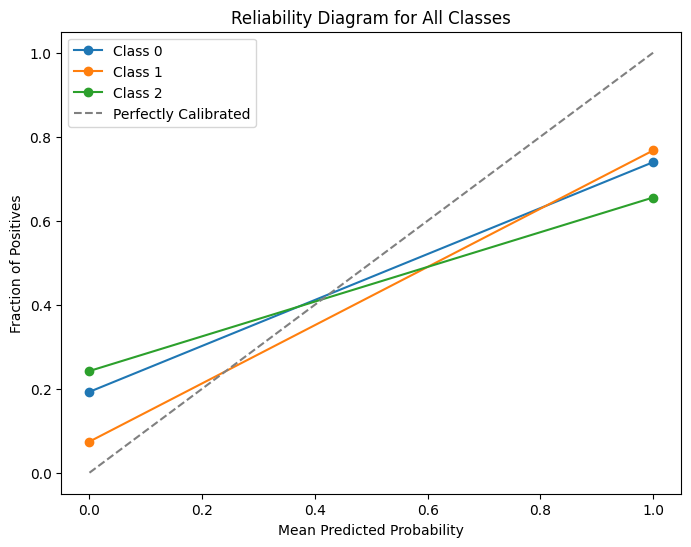

In [62]:
# Create a reliability diagram for each class
plt.figure(figsize=(8, 6))
for class_idx in range(3):
    fraction_of_positives, mean_predicted_value = calibration_curve(y2_test_onehot[:, class_idx], y2_pred_onehot[:, class_idx], n_bins=10)

    # Plot reliability diagram for each class
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', linestyle='-', label=f'Class {class_idx}')

# Plot reference line for a perfectly calibrated model
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram for All Classes')
plt.legend()
plt.show()


# Transfer learning Evaluation  (SHAREw8-TO-ADNI)

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder

# it is in one-hot encoded format, and want to convert it to labels
y_TransferLearning_test_labels = np.argmax(y2_test_onehot, axis=1)

# Convert predicted probabilities to labels
y_TransferLearning_pred_labels = np.argmax(y2_pred_prob, axis=1)

# Calculate and print metrics
accuracy = accuracy_score(y_TransferLearning_test_labels, y_TransferLearning_pred_labels)
precision = precision_score(y_TransferLearning_test_labels, y_TransferLearning_pred_labels, average='weighted')
recall = recall_score(y_TransferLearning_test_labels, y_TransferLearning_pred_labels, average='weighted')
f1 = f1_score(y_TransferLearning_test_labels, y_TransferLearning_pred_labels, average='weighted')
conf_matrix = confusion_matrix(y_TransferLearning_test_labels, y_TransferLearning_pred_labels)
classification_rep = classification_report(y_TransferLearning_test_labels, y_TransferLearning_pred_labels)
kappa = cohen_kappa_score(y_TransferLearning_test_labels, y_TransferLearning_pred_labels)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print('Classification Report:\n', classification_rep)
print(f'Cohen\'s Kappa: {kappa:.4f}')


Accuracy: 0.6930
Precision: 0.7033
Recall: 0.6930
F1 Score: 0.6873
Confusion Matrix:
[[ 417    3  396]
 [   3  356  158]
 [ 144  105 1053]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.51      0.60       816
           1       0.77      0.69      0.73       517
           2       0.66      0.81      0.72      1302

    accuracy                           0.69      2635
   macro avg       0.72      0.67      0.68      2635
weighted avg       0.70      0.69      0.69      2635

Cohen's Kappa: 0.4864


# Baseline model Evaluation (ADNI)

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder

# it is in one-hot encoded format, and want to convert it to labels
y_Baseline_test_labels = np.argmax(y2_test_onehot, axis=1)

# Convert predicted probabilities to labels
y_Baseline_pred_labels = np.argmax(y_pred_prob, axis=1)

# Calculate and print metrics
accuracy_simple = accuracy_score(y_Baseline_test_labels, y_Baseline_pred_labels)
precision_simple = precision_score(y_Baseline_test_labels, y_Baseline_pred_labels, average='weighted')
recall_simple = recall_score(y_Baseline_test_labels, y_Baseline_pred_labels, average='weighted')
f1_simple = f1_score(y_Baseline_test_labels, y_Baseline_pred_labels, average='weighted')
conf_matrix_simple = confusion_matrix(y_Baseline_test_labels, y_Baseline_pred_labels)
classification_rep_simple = classification_report(y_Baseline_test_labels, y_Baseline_pred_labels)
kappa_simple = cohen_kappa_score(y_Baseline_test_labels, y_Baseline_pred_labels)

# Print metrics
print(f'Accuracy: {accuracy_simple:.4f}')
print(f'Precision: {precision_simple:.4f}')
print(f'Recall: {recall_simple:.4f}')
print(f'F1 Score: {f1_simple:.4f}')
print(f'Confusion Matrix:\n{conf_matrix_simple}')
print('Classification Report:\n', classification_rep_simple)
print(f'Cohen\'s Kappa: {kappa_simple:.4f}')


Accuracy: 0.6137
Precision: 0.6961
Recall: 0.6137
F1 Score: 0.5613
Confusion Matrix:
[[ 158    0  658]
 [   2  225  290]
 [  45   23 1234]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.19      0.31       816
           1       0.91      0.44      0.59       517
           2       0.57      0.95      0.71      1302

    accuracy                           0.61      2635
   macro avg       0.75      0.53      0.54      2635
weighted avg       0.70      0.61      0.56      2635

Cohen's Kappa: 0.2954


## Summary

**Initial SHAREw8 Neural Network Training:**

A neural network model is defined with several Dense layers and Dropout layers. This structure aims to prevent overfitting and ensure the model can generalize well on unseen data.
The model is compiled with the adam optimizer and binary_crossentropy loss function, indicating it's set up for a binary classification task.
It is then trained on a split of the SHAREw8 dataset (X_train, y_train_encoded) for a specific number of epochs with batch size and validation data specified.
After training, the model weights are saved to a file (final06_SHAREw8_NNmodel_weights.h5), which contains the learned representations of the SHAREw8 dataset.

**Transfer Learning to ADNI Neural Network:**

A new neural network model for the ADNI dataset is thus defined. While it has a similar structure to the SHAREw8 model, adjustments are made to fit the ADNI dataset's characteristics, such as the input shape and the output layer's activation function (softmax for multi-class classification).

The model then loads the weights from the SHAREw8 model. The load_weights method's by_name=True parameter attempts to match the loaded weights to the layers based on their names. This implies that only the layers with matching names and shapes in both models will receive weights from the SHAREw8 model.

This newly defined ADNI model is compiled and trained on the ADNI dataset (X2_train, y2_train_onehot), however, it starts with the learned weights from the SHAREw8 model, facilitating knowledge transfer.

The process is expected to give the ADNI model a head start in learning, potentially leading to better performance or faster convergence compared to training from scratch.

**Baseline ADNI Neural Network for Comparison:**

A baseline ADNI neural network model (Baseline_ADNI_model) is also defined, compiled, and trained similarly to the transfer learning model but without initializing with weights from the SHAREw8 model. This step is crucial for evaluating the effectiveness of transfer learning by comparing the performance of the baseline model with the transfer learning model.

**Key Points of Transfer Learning Process:**

Transfer learning is effectively used here by transferring weights from a model trained on one dataset (SHAREw8) to initialize a model for a related but different task (ADNI).

This approach is particularly useful when the source and target tasks are similar, allowing the model to leverage the generic features learned from the source task to improve learning efficiency and performance on the target task.

The success of this method depends on the similarity between tasks, the compatibility of model architectures, and the fine-tuning process on the target dataset.
